# Wavelet Search for GRB 230307A INTEGRAL Data

Let's see if we can pin down the changing signal with wavelets:

In [1]:
%matplotlib notebook
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('white')

import numpy as np
import scipy.io
import pickle

import jax
# Important to enable 64-bit precision
jax.config.update("jax_enable_x64", True)

import jax.numpy as jnp
from jax import random
import tensorflow_probability.substrates.jax as tfp

from tinygp import GaussianProcess, kernels
from jaxns.utils import resample

import stingray
from stingray import Lightcurve, Powerspectrum
from stingray.modeling.gpmodeling import get_kernel, get_mean
from stingray.modeling.gpmodeling import get_prior, get_log_likelihood, get_gp_params

# suppress warnings
import warnings
warnings.filterwarnings("ignore")

# abbreviations for tensorflow distributions + bijectors
tfpd = tfp.distributions
tfpb = tfp.bijectors


INFO[2024-03-25 11:51:47,128]: Unable to initialize backend 'cuda': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
I0000 00:00:1711363907.128035       1 tfrt_cpu_pjrt_client.cc:349] TfrtCpuClient created.
INFO[2024-03-25 11:51:47,129]: Unable to initialize backend 'rocm': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
INFO[2024-03-25 11:51:47,145]: Unable to initialize backend 'tpu': INTERNAL: Failed to open libtpu.so: dlopen(libtpu.so, 0x0001): tried: 'libtpu.so' (no such file), '/System/Volumes/Preboot/Cryptexes/OSlibtpu.so' (no such file), '/Users/danielahuppenkothen/work/sw/miniconda3/envs/grbsearch/bin/../lib/libtpu.so' (no such file), '/usr/lib/libtpu.so' (no such file, not in dyld cache), 'libtpu.so' (no such file), '/usr/local/lib/libtpu.so' (no such file), '/usr/lib/libtpu.so' (no such file, not in dyld cache)
/Users/danielahuppenkothen/work/repositories/stingraysoftware/stingray/stingray/utils.py:35: UserWarning: pyfftw not installed.

INFO[2024-03-25 11:51:48,980]: Checking if light curve is well behaved. This can take time, so if you are sure it is already sorted, specify skip_checks=True at light curve creation.
INFO[2024-03-25 11:51:48,980]: Checking if light curve is sorted.
INFO[2024-03-25 11:51:48,981]: Computing the bin time ``dt``. This can take time. If you know the bin time, please specify it at light curve creation


<IPython.core.display.Javascript object>


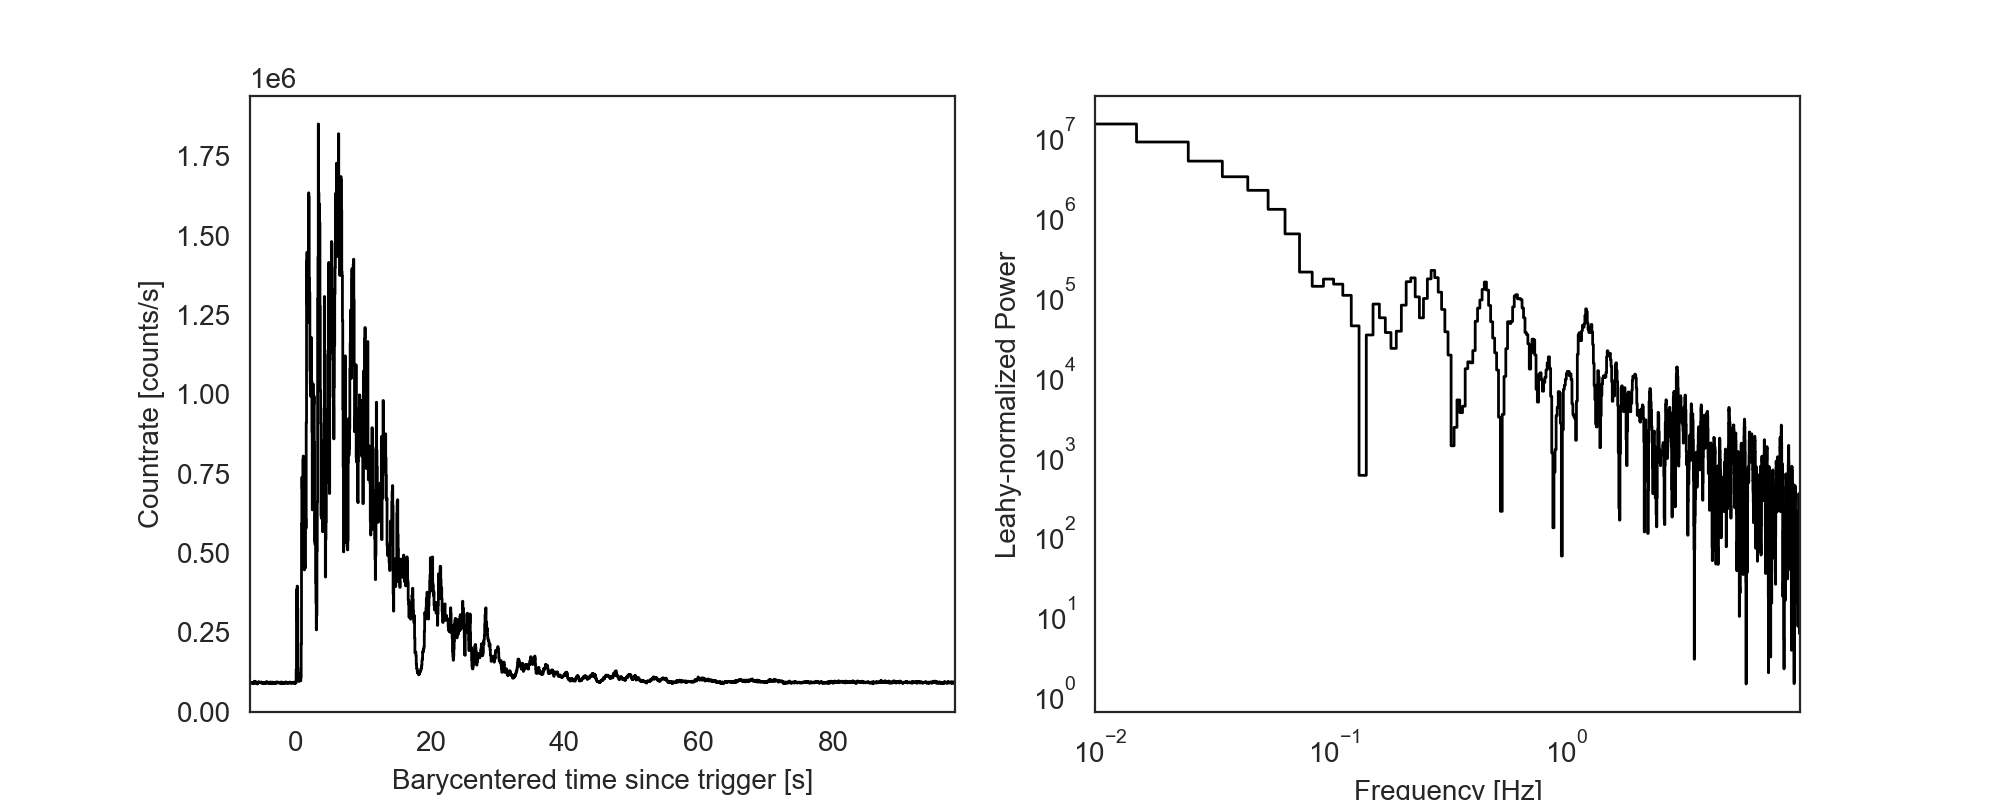

Text(0, 0.5, 'Leahy-normalized Power')

In [2]:
datadir = "/Users/danielahuppenkothen/work/repositories/grb230307a_qposearch/data/"
figdir = "/Users/danielahuppenkothen/work/repositories/grb230307a_qposearch/figures/"

data = scipy.io.readsav(datadir+"acs_lc_bary.sav")

barytime = np.array(data["barytime"], dtype=float)
#minind = barytime.searchsorted(0.0)
#maxind = barytime.searchsorted(60.0)

counts = np.array(data["counts"], dtype=float)

barytime = barytime#[minind:maxind]
counts = counts#[minind:maxind]

#mean_bkg = np.mean(counts[-100:])
mean_bkg = 0.0

lc = Lightcurve(barytime, counts)
#minind = lc.time.searchsorted(0.0)
#maxind = lc.time.searchsorted(60.0)
#lc = lc.truncate(start=minind, stop=maxind, method="index")
ps = Powerspectrum(lc, norm="leahy")

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,4))

ax1.plot(lc.time, lc.countrate, lw=1, color="black", ds="steps-mid")
ax1.set_xlim(lc.time[0], lc.time[-1])
ax1.set_xlabel("Barycentered time since trigger [s]")
ax1.set_ylabel("Countrate [counts/s]")

ax2.loglog(ps.freq, ps.power, ds="steps-mid", lw=1, color="black")
ax2.set_xlim(ps.freq[0], ps.freq[-1])
ax2.set_xlabel("Frequency [Hz]")
ax2.set_ylabel("Leahy-normalized Power")

## Just A Normal Wavelet Transform

Let's do a normal wavelet transform. People seem to use the WWZ, but it's not clear why.

In [3]:
import pywt
wavlist = pywt.wavelist(kind='continuous')

(240, 2101)


<IPython.core.display.Javascript object>


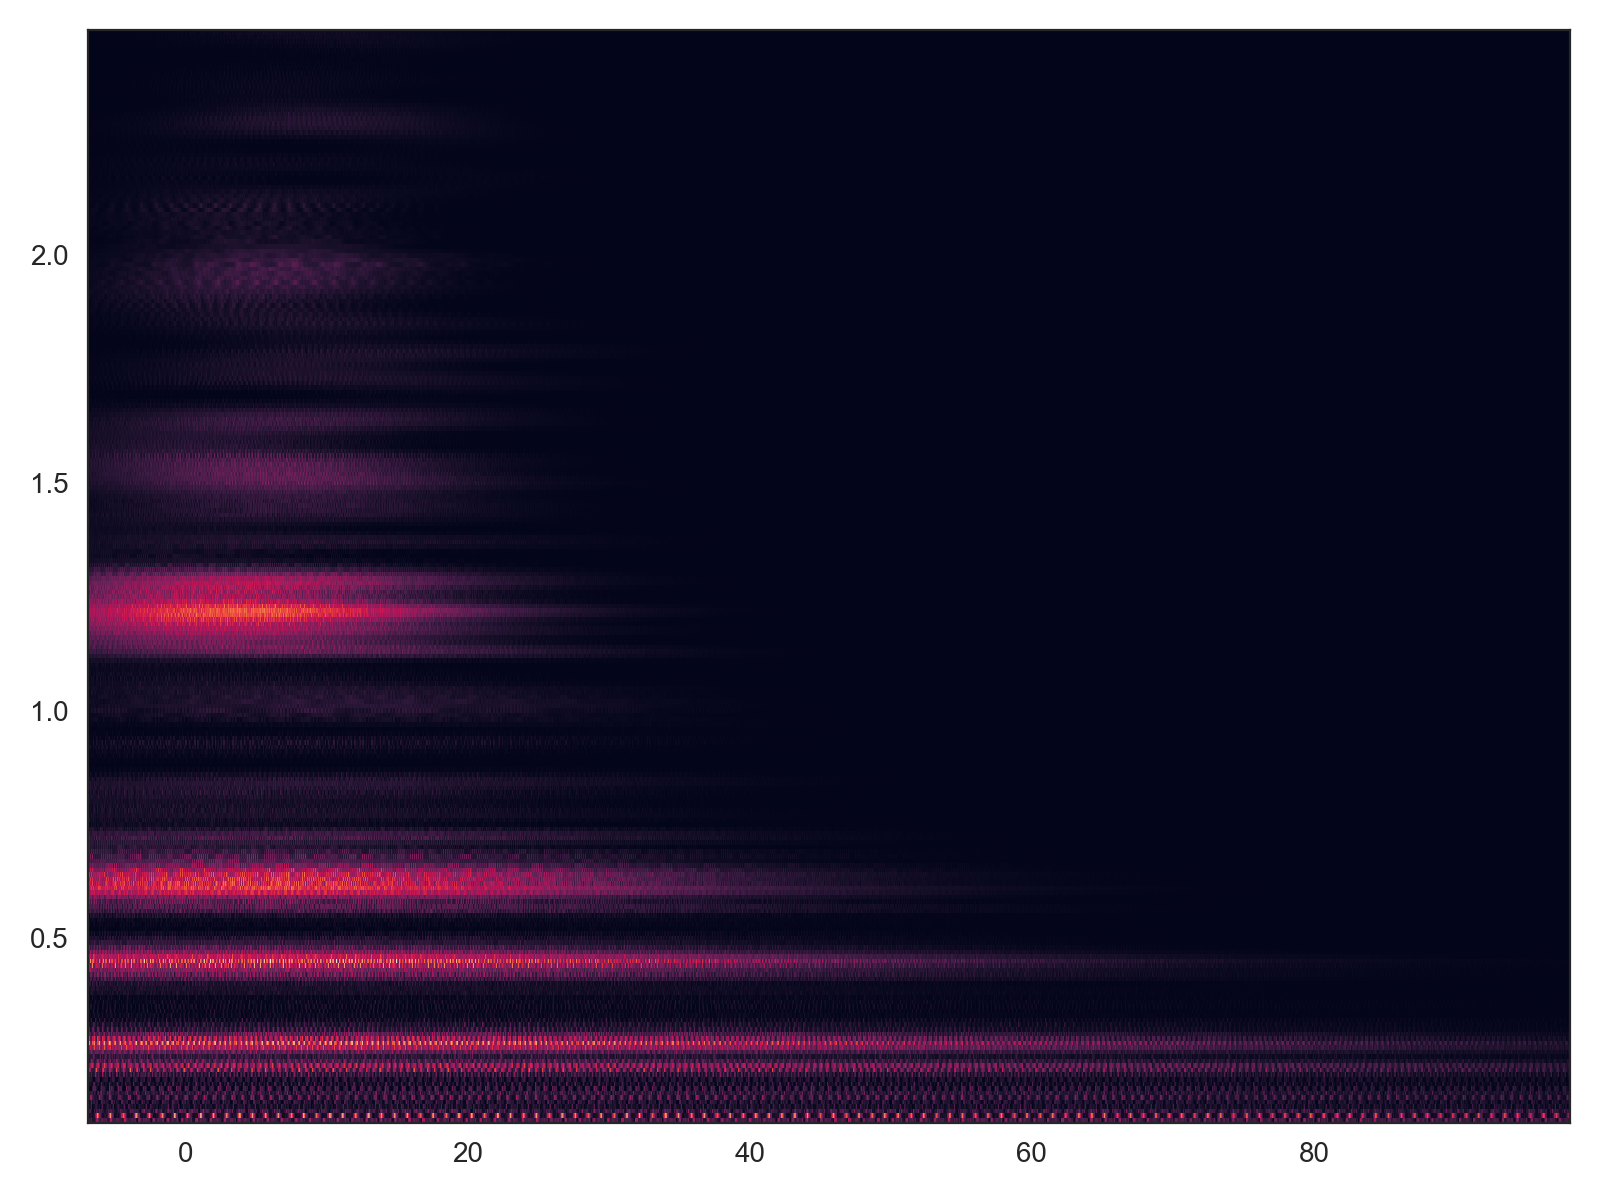

In [4]:
dt = lc.dt
fmax = 1.0/dt
freq_low = 0.1
freq_high = 2.5
freq_steps = 0.01

frequencies = np.arange(freq_low, freq_high, freq_steps)[::-1]/fmax
wavelet = "cmor16.0-6.4"
scales = pywt.frequency2scale(wavelet, frequencies)
ca, cd = pywt.cwt(lc.counts, scales[::-1], wavelet)
print(ca.shape)

X, Y = np.meshgrid(lc.time,cd*fmax)

fig, ax = plt.subplots(1,1, figsize=(8,6))

ax.pcolormesh(X, Y, (np.abs(ca)**2.))
plt.tight_layout()

In [6]:
ca.shape

(240, 2101)

Okay, that seems to broadly work?


## Simulating Red Noise

I mean, I can just simulate from the posterior of the PSD, and then do a comparison that way? It'll be a bad one, but let's do it anyway, because it compares with what people have previously done:

In [7]:
from stingray import Powerspectrum
from stingray.modeling import PSDPosterior, PSDParEst
from astropy.modeling import models
from stingray.modeling import set_logprior
import scipy.stats
from astropy.modeling.fitting import _fitter_to_model_params


In [8]:
# define power law component
pl = models.PowerLaw1D()

# fix x_0 of power law component
pl.x_0.fixed = True

# define constant
c = models.Const1D()

# make compound model
plc = pl + c

log-prior: 1.383646559789373
log-likelihood: -8758.839883394488
log-posterior: -8757.4562368347


<IPython.core.display.Javascript object>


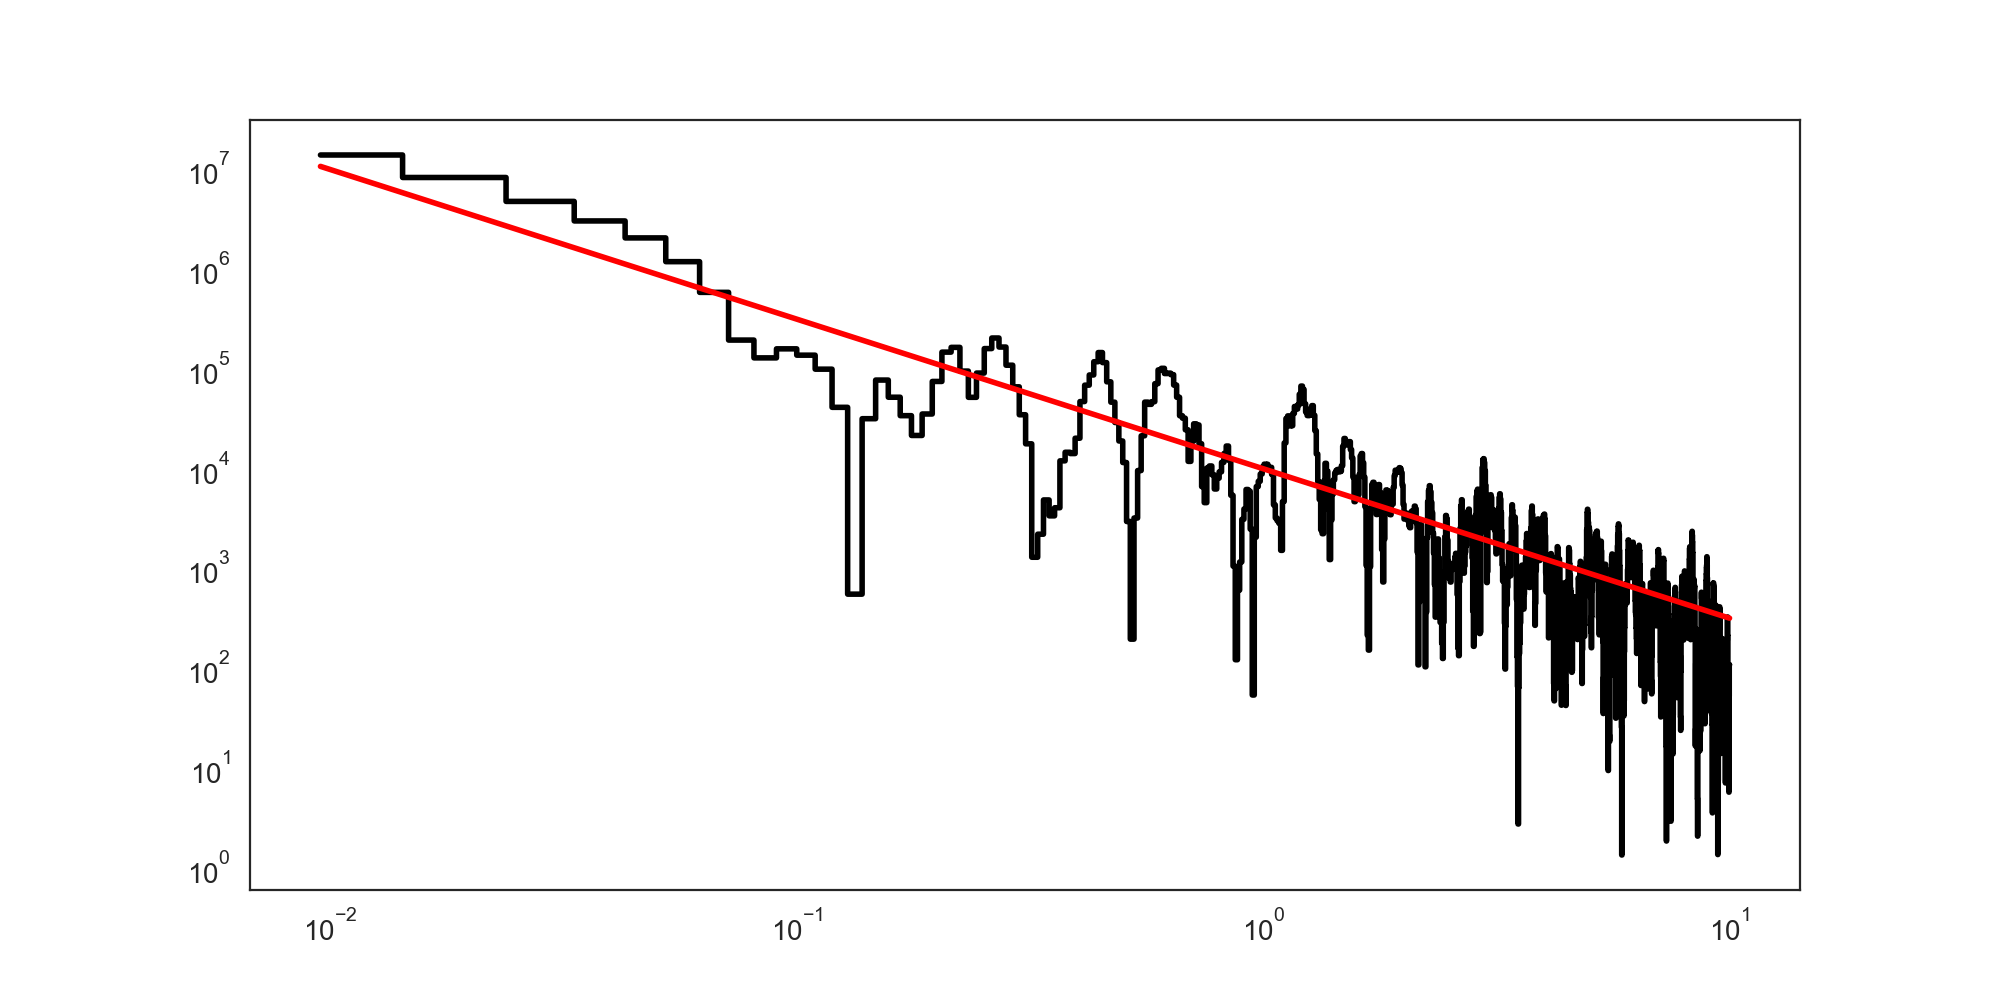

In [9]:
# flat prior for the power law index
p_alpha = lambda alpha: ((-1. <= alpha) & (alpha <= 5.))

# flat prior for the power law amplitude
p_amplitude = lambda amplitude: ((1 <= amplitude) & (amplitude <= 1e8))

# normal prior for the white noise parameter
p_whitenoise = lambda white_noise: scipy.stats.norm(2.0, 0.1).pdf(white_noise)

priors = {}
priors["alpha_0"] = p_alpha
priors["amplitude_0"] = p_amplitude
priors["amplitude_1"] = p_whitenoise

lpost = PSDPosterior(ps.freq, ps.power, plc, m=ps.m)
lpost.logprior = set_logprior(lpost, priors)

test_pars = [1e4, 1.5, 2.0]
print("log-prior: " + str(lpost.logprior(test_pars)))
print("log-likelihood: " + str(lpost.loglikelihood(test_pars)))
print("log-posterior: " + str(lpost(test_pars)))

_fitter_to_model_params(plc, test_pars)

fig, ax = plt.subplots(1, 1, figsize=(10,5))

ax.loglog(ps.freq, ps.power, lw=2, color="black", ds="steps-mid")
ax.plot(ps.freq, plc(ps.freq) , lw=2, color="red")

<IPython.core.display.Javascript object>


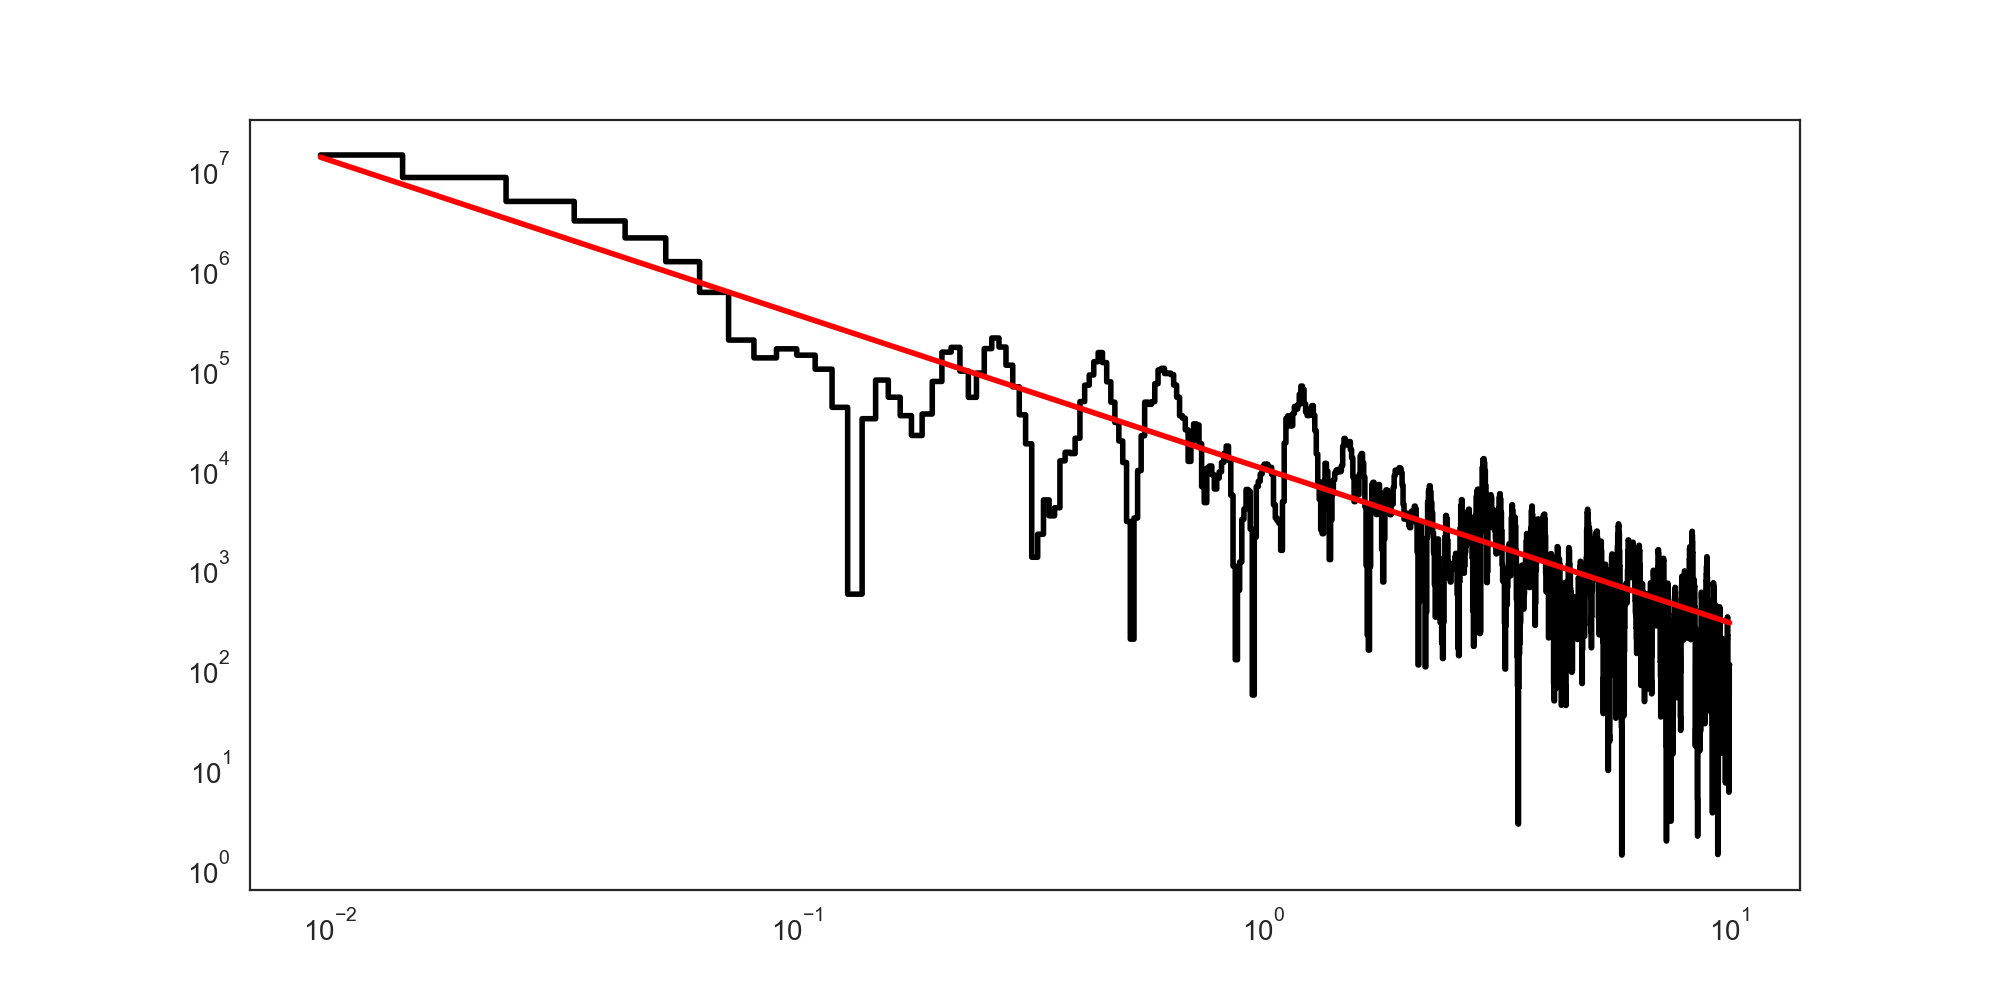

In [10]:
parest = PSDParEst(ps, fitmethod='l-bfgs-b', max_post=True)
res = parest.fit(lpost, test_pars)

fig, ax = plt.subplots(1, 1, figsize=(10,5))

ax.loglog(ps.freq, ps.power, lw=2, color="black", ds="steps-mid")
ax.plot(ps.freq, res.mfit, lw=2, color="red")

In [11]:
post_samples = np.loadtxt(datadir + "grb230307a_integral_pl_sample.txt")

## Simulating light curves with power-law spectra:

In [12]:
from stingray.simulator.simulator import Simulator

Time resolution of the simulated light curves: 0.04999971389770508
Number of time bins in the simulated light curves: 2101
Mean number of counts per bin in the simulated light curves: 11781.493574488339


<IPython.core.display.Javascript object>


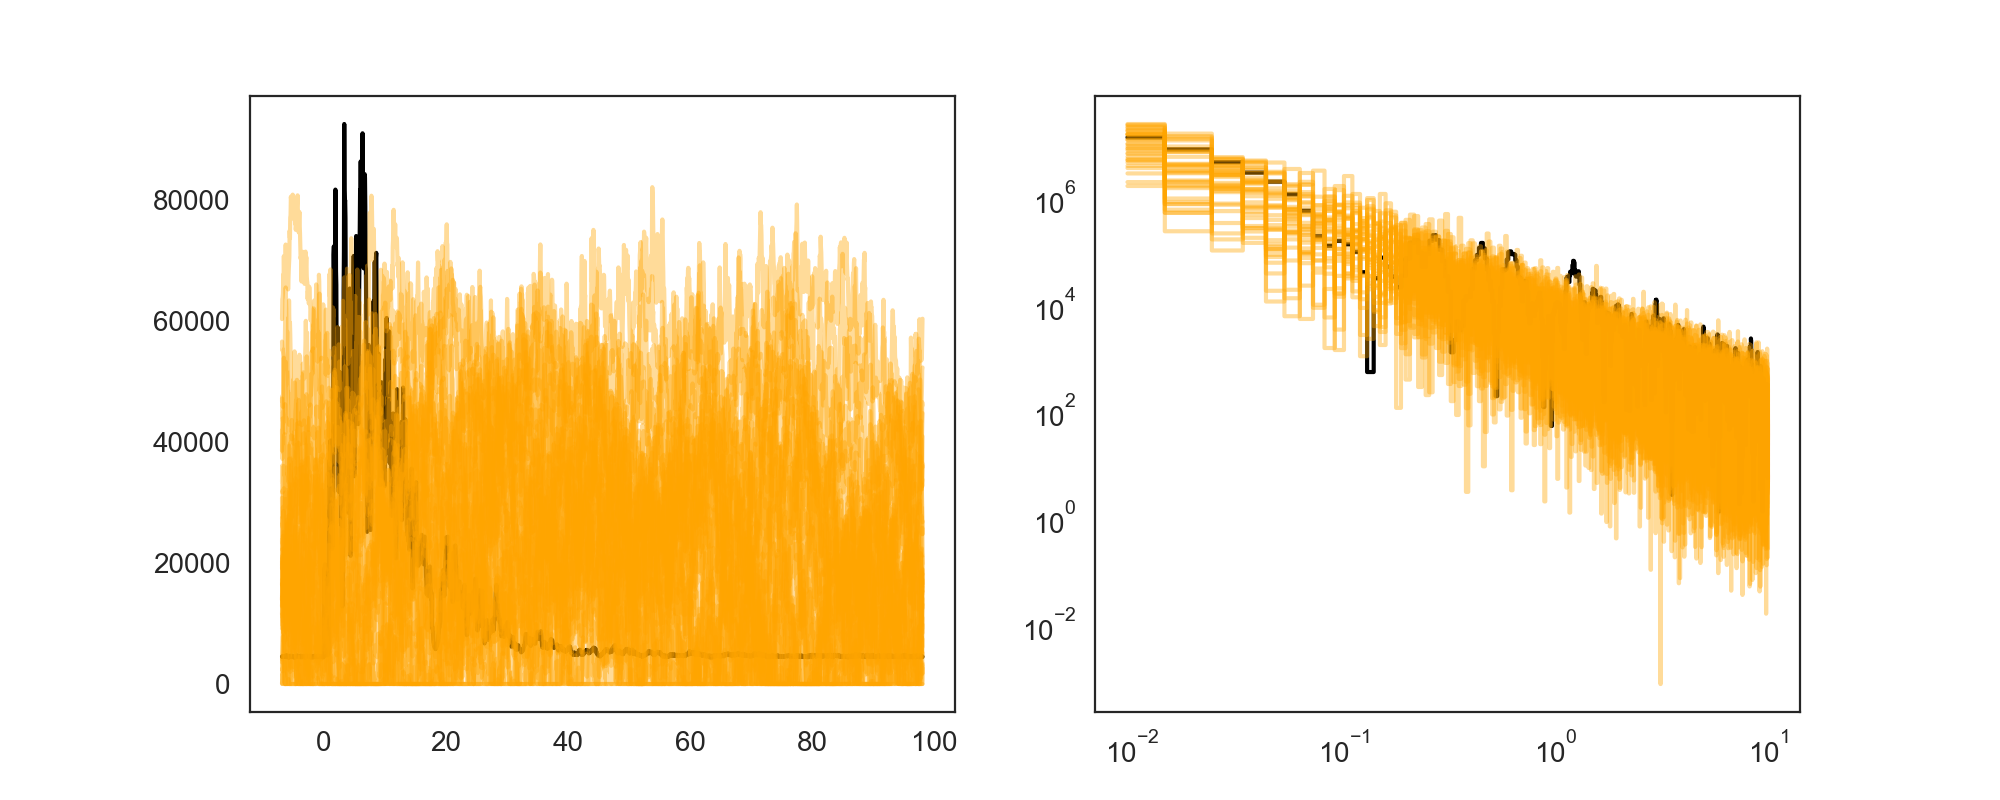

0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300


KeyboardInterrupt: 

In [13]:
dt = lc.dt
print("Time resolution of the simulated light curves: " + str(dt))

nbins = int(lc.tseg/lc.dt)
print("Number of time bins in the simulated light curves: " + str(nbins))

mean_counts = np.mean(lc.counts)
print("Mean number of counts per bin in the simulated light curves: " + str(mean_counts))

sim = Simulator(dt=dt, N=nbins, mean=mean_counts+10000, rms=0.9, tstart = lc.time[0])

# exponential version
#sim = Simulator(dt=dt, N=nbins, mean=np.log(mean_counts), rms=0.1, tstart = lc.time[0])

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,4))

ax1.plot(lc.time, lc.counts, color="black")
ax2.loglog(ps.freq, ps.power, ds="steps-mid", color="black")

ca_sim_all = []

nsims = 3000
idx_all = np.random.choice(np.arange(post_samples.shape[0]), size=nsims, replace=False)

for i, idx in enumerate(idx_all):
    _fitter_to_model_params(plc, post_samples[idx])

    pl_model = plc(ps.freq)
    lc_sim = sim.simulate(pl_model)
    
    # non-exponential version:
    lc_sim.counts[lc_sim.counts < 0] = 0.0
    counts = np.random.poisson(lc_sim.counts)
    
    # exponential version
    #counts = np.random.poisson(np.exp(lc_sim.counts))
    
    lc_sim = Lightcurve(lc_sim.time, counts, dt=lc_sim.dt, skip_checks=True)
    ps_sim = Powerspectrum(lc_sim, norm="leahy")
    
    if i % 100 == 0:
        print(i)
        ax1.plot(lc_sim.time, lc_sim.counts, color="orange", alpha=0.4)
        ax2.loglog(ps_sim.freq, ps_sim.power, ds="steps-mid", color="orange", alpha=0.4)

    ca_sim, cd_sim = pywt.cwt(lc_sim.counts, scales[::-1], wavelet)
    ca_sim_all.append(ca_sim)
    
ca_sim_all = np.array(ca_sim_all)

In [14]:
ca_sim_all = np.array(ca_sim_all)

Let's save those to file so I don't have to keep running them:

In [16]:
np.save(datadir + "grb230307a_intergral_cmor16.0-6.4_rednoisesims.npy", ca_sim_all)

Let's make many of these and then calculate the wavelet transform and save all of those so I can do cool stuff with it:

<IPython.core.display.Javascript object>


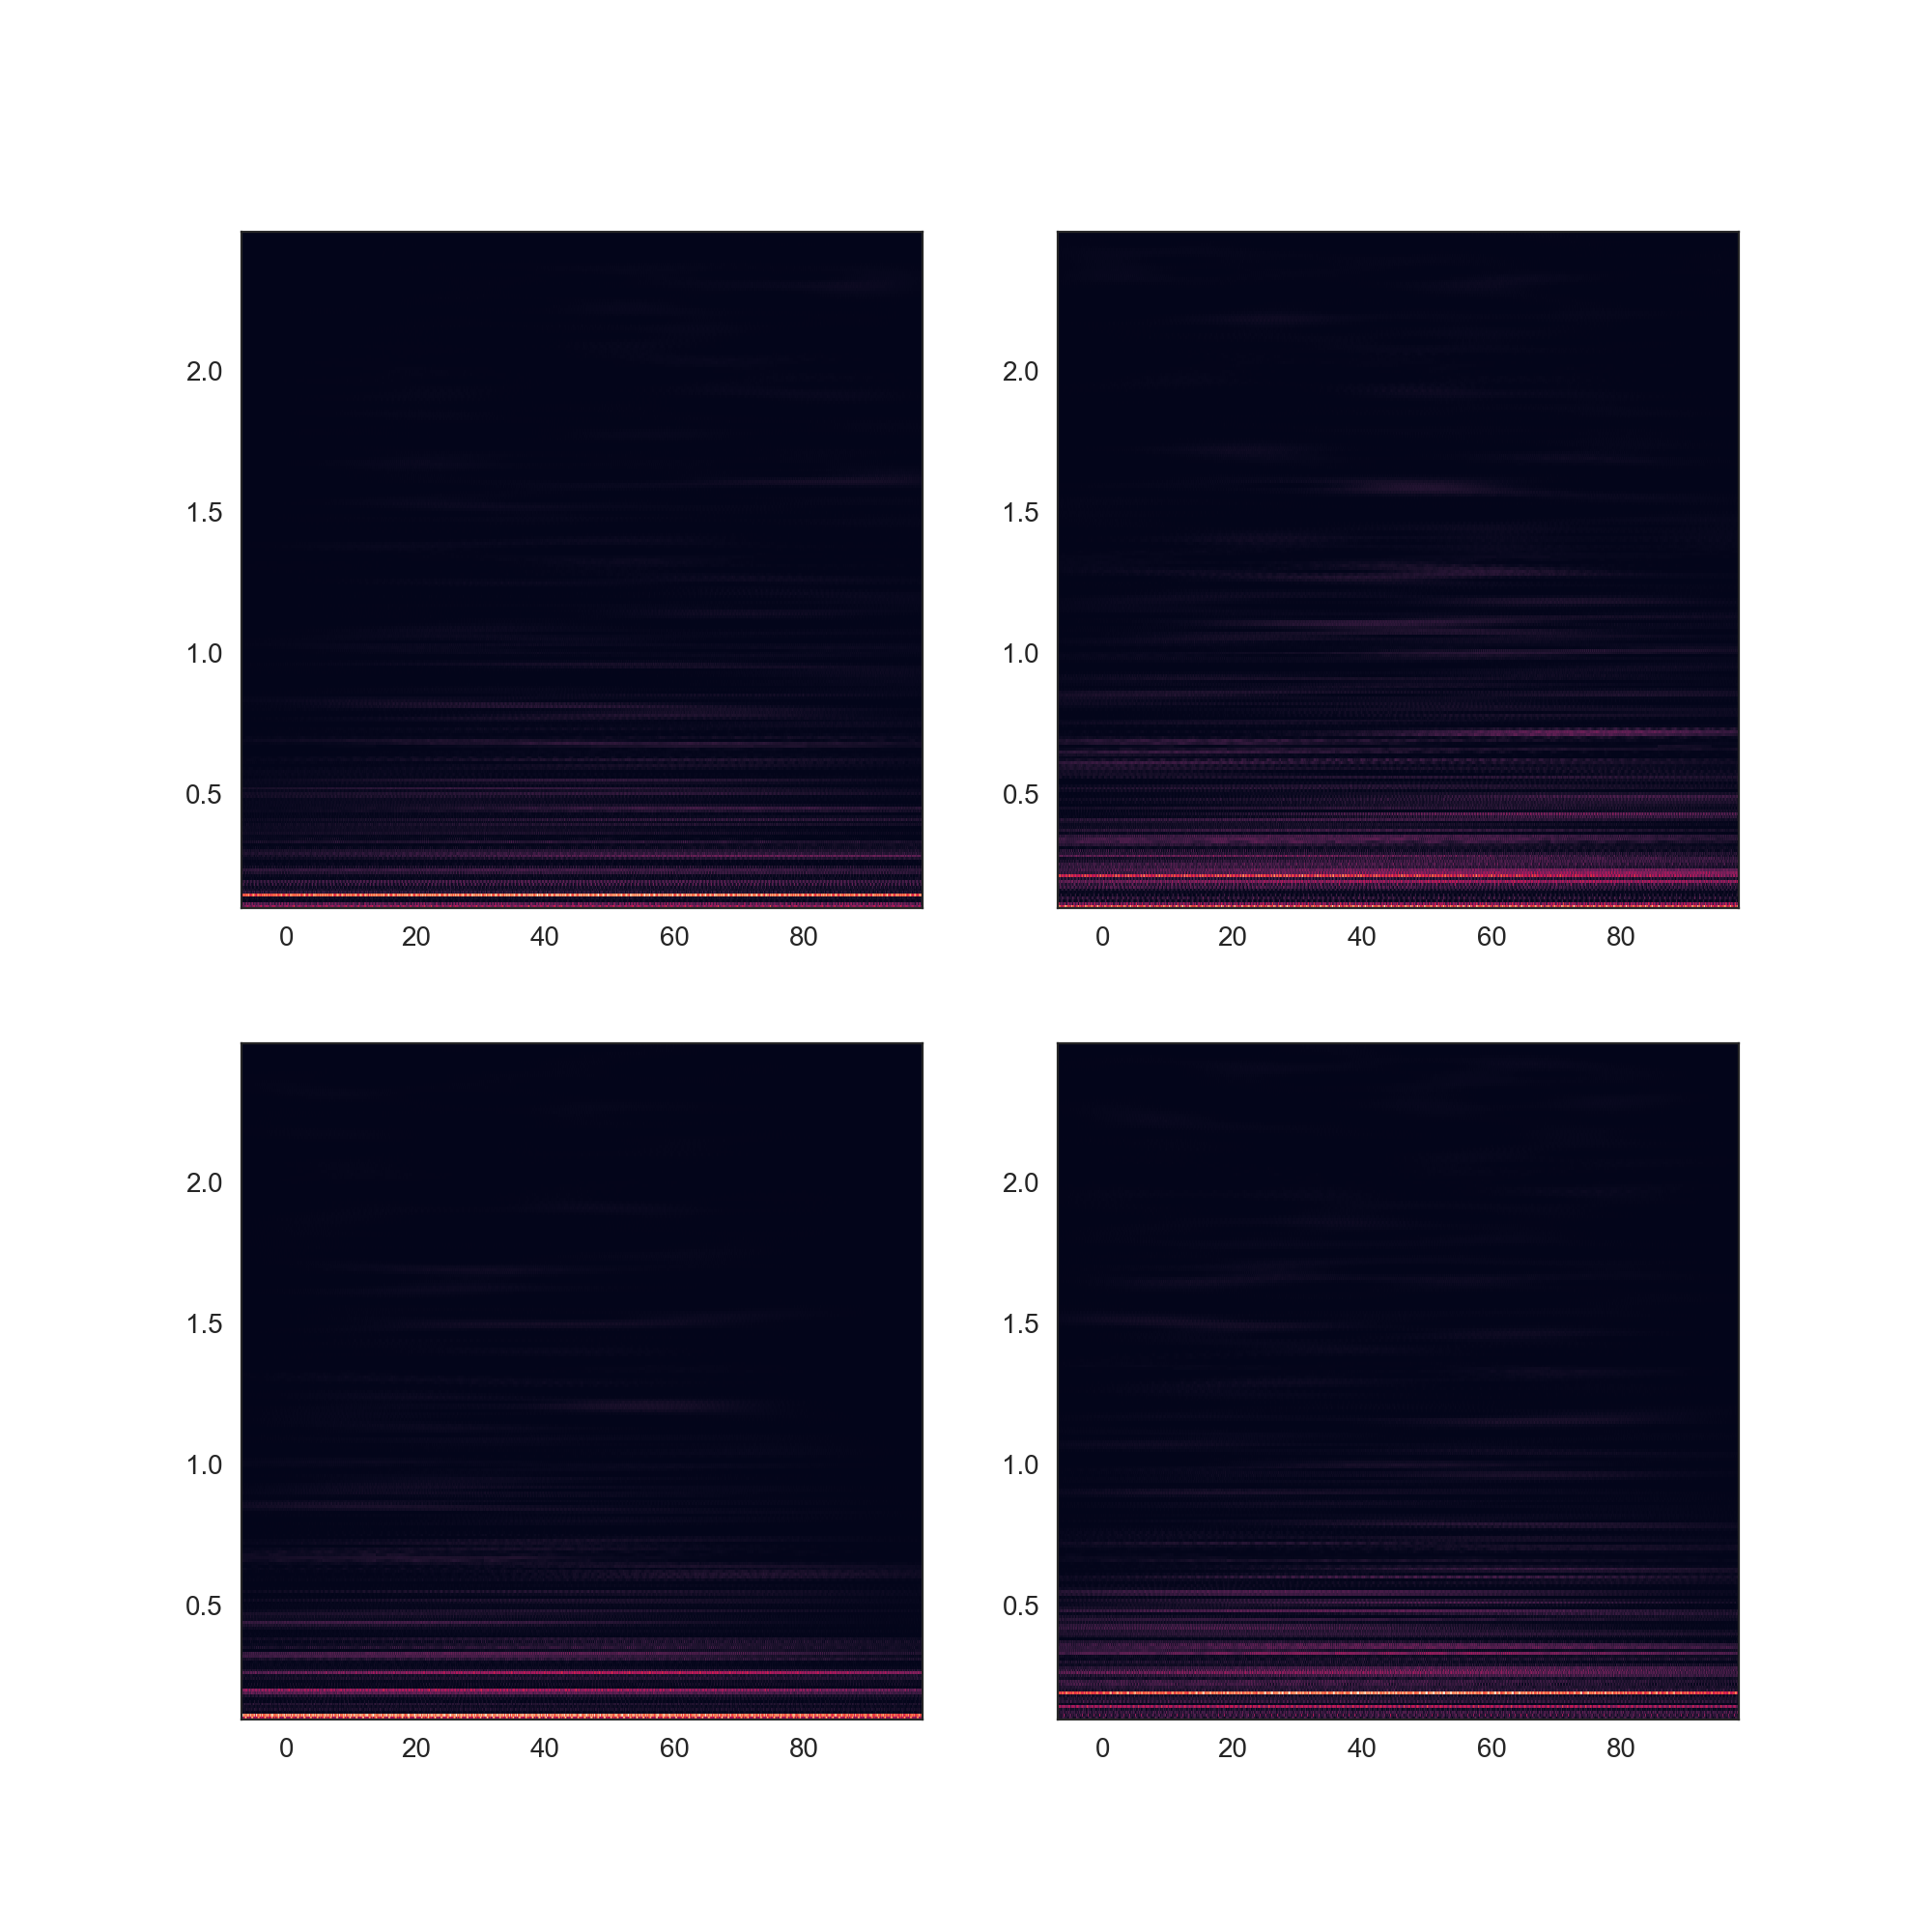

In [17]:
nrows = 2
ncols = 2
fig, axes = plt.subplots(nrows, ncols, figsize=(10, 10))

axes = np.hstack(axes)

for i in range(nrows*ncols):
    axes[i].pcolormesh(X, Y, (np.abs(ca_sim_all[i+4])**2.))
  

In [18]:
w_sim_all = np.abs(ca_sim_all)**2.
w_obs =  np.abs(ca)**2

In [28]:
w_perc = np.percentile(w_sim_all, [50, 68.5, 95.0, 99.7], axis=0)

<IPython.core.display.Javascript object>


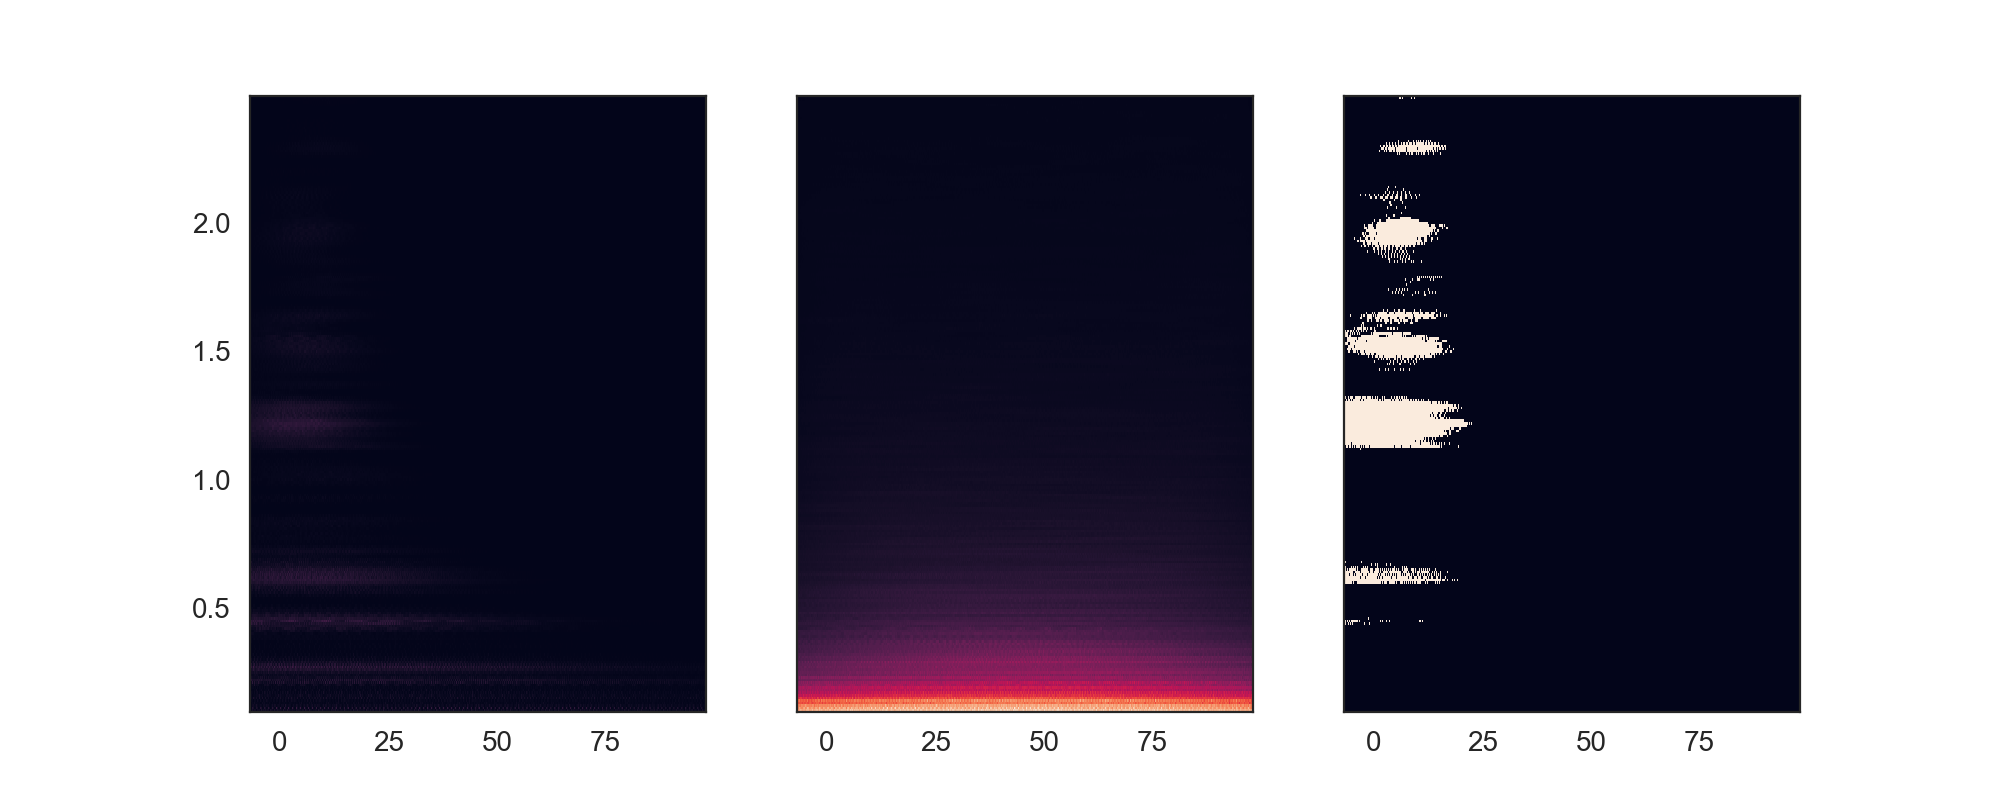

(array([35]), array([258]))


In [29]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(10, 4), sharex=True, sharey=True)

vmin = np.min([np.min(w_obs), np.min(w_perc[-1,:,:])])
vmax = np.max([np.max(w_obs), np.max(w_perc[-1, :, :])])

ax1.pcolormesh(X, Y, np.abs(ca)**2., vmin=vmin, vmax=vmax)
ax2.pcolormesh(X, Y, w_perc[-1,:,:], vmin=vmin, vmax=vmax)

ax3.pcolormesh(X, Y, w_obs > w_perc[-1,:,:])

max_w = np.max(w_obs)
max_w_idx = np.where(w_obs == np.max(w_obs))
max_f = cd[max_w_idx[0][0]]*fmax
max_t = lc.time[max_w_idx[1][0]]

#ax3.scatter(max_t, max_f, color="red", s=50)
print(max_w_idx)


In [30]:
np.save(datadir + "grb230307a_intergral_cmor16.0-6.4_percentiles.npy", w_perc)

What if I look at the maximum outlier in the entire wavelet spectrum?

In [31]:
max_sim = np.array([np.max(wp) for wp in w_perc[-1, :, :]])

<IPython.core.display.Javascript object>


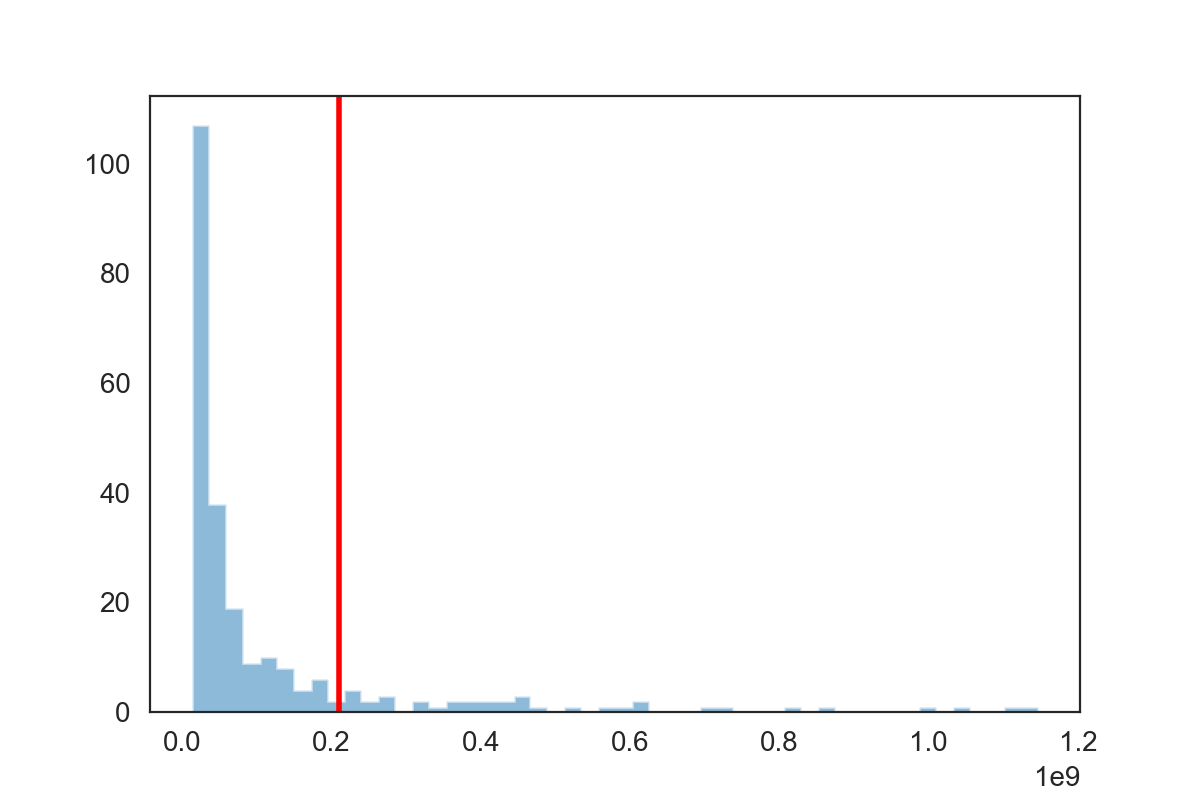

In [32]:
fig, ax = plt.subplots(1, 1, figsize=(6,4))

ax.hist(max_sim, bins=50, histtype="stepfilled", alpha=0.5)

ax.axvline(np.max(w_obs), lw=2, color="red")


In [33]:
np.sum(max_sim > np.max(w_obs)) / len(max_sim)

0.15833333333333333

In [36]:
del ca_sim_all

## WWZ of the Whole Thing

Let's do a weighted wavelet z-transform. I should probably look this up better.

* constant $c$ determines how rapidly the analyzing wavelet decays, usually chosen so exponential term decreases significantly in a single cycle $2\pi/\omega$ 
* popular choice is $1/8\pi^2$ (but could also treat it as a parameter), here choose $c=0.0125$, which is close

In [ ]:
import libwwz
import libwwz.plot_methods as wwz_plot

In [ ]:
ntime = 30
freq_low = 0.1
freq_high = 2.5
freq_steps = 0.01
freq_lin = [freq_low, freq_high, freq_steps]

f = 10
w = 2 * np.pi * f
c = 1/(2*w**2)
#c= 0.000125
print(c)
wwz = libwwz.wwt(lc.time, lc.counts, ntime, freq_lin, c)

fig, ax = plt.subplots(1, 1)

wwz_plot.linear_plotter(ax=ax, TAU=wwz[0],
                        FREQ=wwz[1],
                        DATA=wwz[2])
ax.set_ylabel('full data (Hz)')
ax.set_yticks(np.arange(0.1, 2.5, 0.1))
ax.set_title('WWZ')


**TODO**: 
* Read Foster paper (what are the important quantities?
* based on that, I probably need a model with more than one QPO?
* try to get the multiplicative model to work, so I can generate realistic example light curves